##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments

In [2]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [3]:
from tools.quantum_tools import trotter_circuit, state_operator, measure_operator, quantum_operator_single_sxx, quantum_operator_single_sz
from tools.classical_tools import classical_simulator, state_probability, operator_sz, operator_sxx, expectation_value

In [25]:
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, ylim, text
from numpy import linspace, pi, zeros_like, zeros, divide, array, arange, flipud
from itertools import combinations
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile
from seaborn import heatmap

## Probability of all spins up and energy variation
---
### Classical simulation

In [51]:
# Checking if the hamiltonian is correct
spins = 8 # Number of 2-level systems
coupling = 1
frequency = 0.3

In [52]:
%%time
times, probabilities, internal_energy, coupling_energy = classical_simulator([0, 2 * pi], 500, spins, frequency, coupling)

CPU times: user 1min 9s, sys: 1.58 s, total: 1min 11s
Wall time: 17.9 s


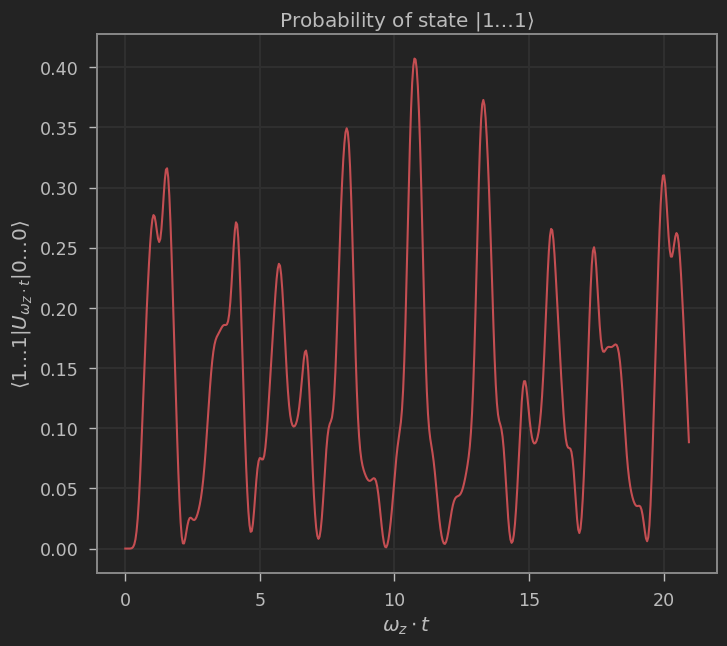

In [53]:
plot(times, probabilities, '-r')
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
show()

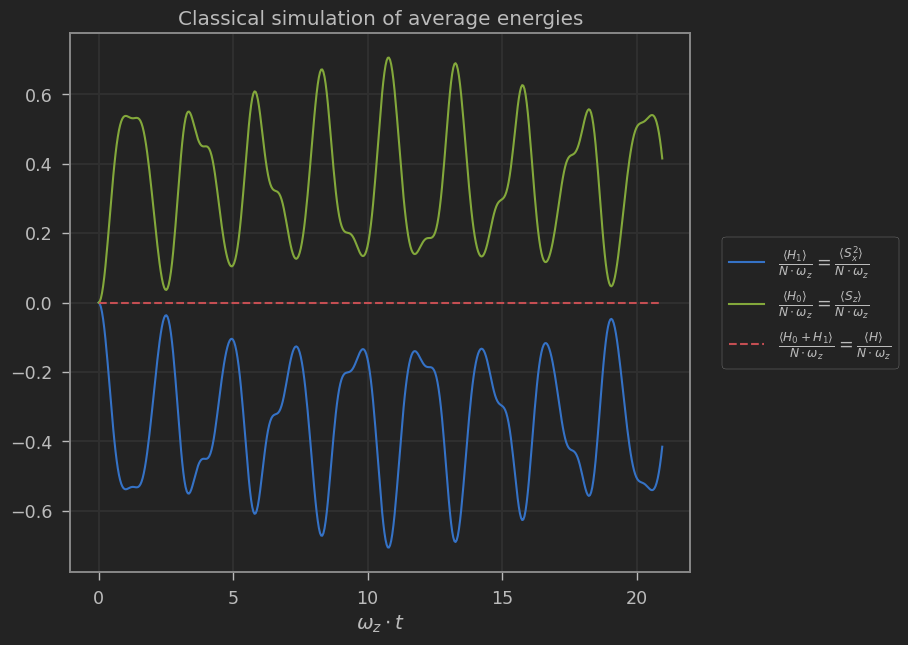

In [54]:
plot(times, coupling_energy, label = r'$\frac{\langle H_1\rangle}{N\cdot\omega_z}=\frac{\langle S_x^2\rangle}{N\cdot\omega_z} $' )    
plot(times, internal_energy, label = r'$\frac{\langle H_0\rangle}{N\cdot\omega_z}=\frac{\langle S_z\rangle}{N\cdot\omega_z} $' )  
plot(times, internal_energy + coupling_energy, '--', label = r'$\frac{\langle H_0 + H_1\rangle}{N\cdot\omega_z}=\frac{\langle H\rangle}{N\cdot\omega_z} $' )  
legend(loc = 'center right', bbox_to_anchor = (1.35, 0.5))
title(r'Classical simulation of average energies')
xlabel(r'$\omega_z \cdot t$')
show()

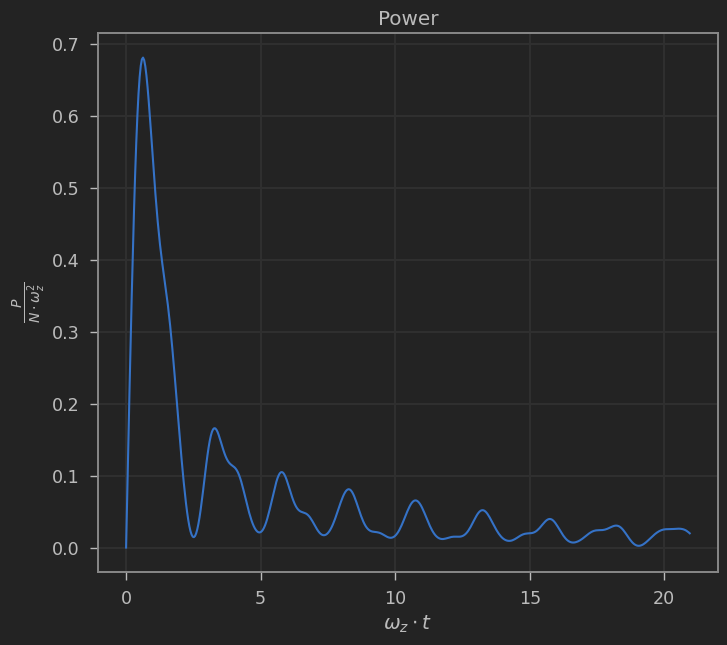

In [55]:
plot(times, divide(internal_energy, times, out = zeros_like(internal_energy), where = times != 0))
title(r'Power')
ylabel(r'$\frac{P}{N\cdot\omega_z^2}$')
xlabel(r'$\omega_z \cdot t$')
show()

In [56]:
%%time
maximum_spins = 7
couplings = arange(0.1, 1.5, 0.1).round(decimals = 2)
maximum_power = array([zeros_like(couplings) for _ in range(maximum_spins - 1)])

for j, g in enumerate(couplings):
    for i in range(2, maximum_spins + 1):
        times, _, internal_energy, _ = classical_simulator([0, 2 * pi], 50, i, frequency, g)
        power = divide(internal_energy, times, out = zeros_like(internal_energy), where = times != 0)
        maximum_power[1 - i][j] = power.max()

CPU times: user 22.4 s, sys: 708 ms, total: 23.2 s
Wall time: 5.82 s


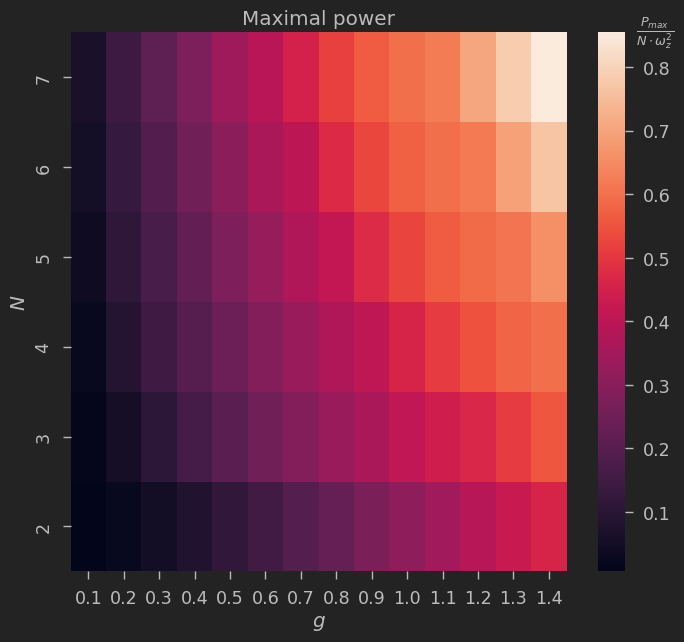

In [57]:
figure = heatmap(maximum_power, xticklabels = couplings, yticklabels = [i for i in range(maximum_spins, 1, -1)])
title('Maximal power')
xlabel(r'$g$')
ylabel(r'$N$')
text(16.5, 0.0, r'$\frac{P_{max}}{N\cdot\omega_z^2}$', horizontalalignment = 'center', verticalalignment = 'center')
show()

In [58]:
plotcontour(couplings, [i for i in range(2, maximum_spins + 1)], flipud(maximum_power))

### Quantum simulation

In [59]:
quantum_times = linspace(0, 2 * pi / frequency, 50)
shots = 1500

In [ ]:
quantum_probabilities = zeros_like(quantum_times)
quantum_magnetization = zeros_like(quantum_times)
quantum_coupling_energy = zeros_like(quantum_times)

for i, t in enumerate(quantum_times):
    circuit = trotter_circuit(spins, t, 15, frequency, coupling)
    state_up = state_operator([0 for _ in range(spins)])
    quantum_probabilities[i] = measure_operator(state_up, circuit, shots)
    
    for j in range(spins):
        operator = quantum_operator_single_sz(spins, j)
        quantum_magnetization[i] += measure_operator(operator, circuit, shots)
        quantum_magnetization[i] += 1 / 2
        
    quantum_magnetization[i] /= spins  
     
    for pair in combinations(range(spins), 2):
        operator = quantum_operator_single_sxx(spins, *pair)
        quantum_coupling_energy[i] -= measure_operator(operator, circuit, shots)
        
    quantum_coupling_energy[i] *= 2 * coupling
    quantum_coupling_energy[i] /= spins * frequency

In [ ]:
plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, quantum_probabilities, '.', label = "Quantum simulation")
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

In [ ]:
plot(times, magnetization, '--')
plot(quantum_times, quantum_magnetization, '.')
plot(times, coupling_energy, '--')
plot(quantum_times, quantum_coupling_energy, '.')
show()